# Prediction of 'Crash Severity' using data from UConn Crash Repository covering New Haven County from 01/01/2020 to 05/01/2023

### Load the 2 CSVs exported from UConn Crash Data Repository and combine the desired columns into a new file
 - drop unwanted columns
 - encode the column to be predicted as integers
 - save as a new, cleaned CSV

In [84]:
#load both CSVs as dataframes
import pandas as pd

#ignore the first row of the csv, since it just contains the URL for the export
df1 = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/Raw Data/export_160155_0.csv', skiprows=1, index_col='CrashId')

#remove the label from the index column, so the dataframe does not have multiple label levels
df1.index.name = None

#ignore the first row of the csv, since it just contains the URL for the export
df2 = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/Raw Data/export_160155_1.csv', skiprows=1, index_col='CrashId', encoding='windows-1252')

#remove the label from the index column, so the dataframe does not have multiple label levels
df2.index.name = None

print(df1.columns)

print(df2.head())

/var/folders/cp/7f1dc54j6gv87v30bs8sfvzc0000gp/T/ipykernel_17627/795650243.py:5: DtypeWarning: Columns (84,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/Raw Data/export_160155_0.csv', skiprows=1, index_col='CrashId')
/var/folders/cp/7f1dc54j6gv87v30bs8sfvzc0000gp/T/ipykernel_17627/795650243.py:11: DtypeWarning: Columns (67,68,70,76,81,87,88,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/Raw Data/export_160155_1.csv', skiprows=1, index_col='CrashId', encoding='windows-1252')


Index(['Fatal Case Status', 'Fatal Case Status Text Format', 'CrashId.1',
       'CrashId.2', 'Latitude', 'Longitude', 'DOT Case Number', 'Town Name',
       'Town Number', 'Town Number.1',
       ...
       'Urban Area Text Format', 'No. of Through Lanes (Reverse Dir.)',
       'No. of Through Lanes (Log Dir.)', 'Highway Type (FHWA)',
       'Highway Type (FHWA) Text Format', 'Average Daily Traffic',
       'Functional Classification', 'Functional Classification Text Format',
       'Rural or Urban', 'Rural or Urban Text Format'],
      dtype='object', length=107)
        VehicleId  Vehicle Unit Type Vehicle Unit Type Text Format  \
632460          1                  1          Vehicle in Operation   
632460          2                  1          Vehicle in Operation   
632557          1                  1          Vehicle in Operation   
632557          2                  1          Vehicle in Operation   
632558          1                  1          Vehicle in Operation   

       

In [85]:
#drop the unwanted columns and combine the two dataframes 

#get just the desired columns from df1

df1 = df1[['Crash Severity Text Format', 'Latitude', 'Longitude', 'Date Of Crash', 'Time of Crash', 'Hour of the Day', 'Most Severe Injury Text Format','Number Of Motor Vehicles', 'Number Of Non-Motorist', 'Route Class Text Format', 'Road Number', 'Weather Condition Text Format', 'Light Condition Text Format', 'Road Surface Condition Text Format', 'Type of Intersection Text Format']]

#check its length
print(len(df1))

#get just the desired columns from df2
df2 = df2[['Posted/Statutory Speed Limit', 'Trafficway Description Text Format', 'Total Lanes In Roadway', 'Extent of Damage Text Format', 'Body Type Text Format']]

#check its length
print(len(df2))

#merge the two dataframes - note that df2 contains entries for each car involved in an accident, so the df1 data will be 
# duplicated for each automobile (which is fine, since the df1 data applies to all vehicles in an accident)
df = df1.merge(df2, left_index=True, right_index=True)

#check whole df length
print(len(df))

#drop the ' Text Format' part of any column names that include it
df.columns = df.columns.str.replace(' Text Format', '')
#print a list of the columns
print(df.columns)


88259
167621
167621
Index(['Crash Severity', 'Latitude', 'Longitude', 'Date Of Crash',
       'Time of Crash', 'Hour of the Day', 'Most Severe Injury',
       'Number Of Motor Vehicles', 'Number Of Non-Motorist', 'Route Class',
       'Road Number', 'Weather Condition', 'Light Condition',
       'Road Surface Condition', 'Type of Intersection',
       'Posted/Statutory Speed Limit', 'Trafficway Description',
       'Total Lanes In Roadway', 'Extent of Damage', 'Body Type'],
      dtype='object')


In [86]:
#check how many nans are in the column to be predicted

#this is the column that I will attempt to predict, so check its values
print(df['Crash Severity'].unique())

#create a new dataframe that contains 'True' for any instances of '?'
bool_df = (df.isna())

# Now sum up the True values in each column
print(bool_df.sum(axis = 0))

#drop the rows that have nans in this column
df = df.dropna(subset=['Crash Severity'])

#now check length of dataframe and presence of nans
print(len(df))
bool_df = (df.isna())
print(bool_df.sum(axis = 0))

['Injury of any type (Serious, Minor, Possible)' 'Property Damage Only'
 'Fatal (Kill)']
Crash Severity                      0
Latitude                            0
Longitude                           0
Date Of Crash                       0
Time of Crash                       0
Hour of the Day                     0
Most Severe Injury                205
Number Of Motor Vehicles            0
Number Of Non-Motorist              0
Route Class                      4609
Road Number                      5112
Weather Condition                   0
Light Condition                     0
Road Surface Condition              0
Type of Intersection                0
Posted/Statutory Speed Limit     8722
Trafficway Description             17
Total Lanes In Roadway          11907
Extent of Damage                    0
Body Type                         405
dtype: int64
167621
Crash Severity                      0
Latitude                            0
Longitude                           0
Date Of Crash    

In [87]:
#save the cleaned and processed data to a new csv
df.to_csv('crashes_cleaned.csv')

In [88]:
#see what labels are present in the column to be predicted
df['Extent of Damage'].value_counts()

Minor Damage         65097
Disabling Damage     47235
Functional Damage    38129
Unknown               8932
No Damage             8228
Name: Extent of Damage, dtype: int64

In [89]:
#drop the columns that won't be used for training and replace Injury Text with an integer scale (0-4) 
# then one hot encode nominal values

df.drop(columns=['Latitude','Longitude','Date Of Crash','Road Number', 'Time of Crash', 'Extent of Damage'], inplace=True)

#replace injury descriptions with integer range representing severity, rename the column
df['Crash Severity'] = df['Crash Severity'].replace('Property Damage Only', 0)
df['Crash Severity'] = df['Crash Severity'].replace('Injury of any type (Serious, Minor, Possible)', 1)
df['Crash Severity'] = df['Crash Severity'].replace('Fatal (Kill)', 2)

#check to make sure all labels were replaced properly
df['Crash Severity'].unique()

df_encoded = pd.get_dummies(data = df, columns = ['Hour of the Day', 'Route Class', 'Weather Condition', 'Light Condition', 'Road Surface Condition', 'Type of Intersection', 'Trafficway Description', 'Body Type'])
df_encoded.head()

#save this encoded version as a csv
df_encoded.to_csv('crashes_encoded.csv')

In [66]:
# #encode a different version for predicting 'Extent of Damage'
# import numpy as np

# df.drop(columns=['Latitude','Longitude','Date Of Crash','Road Number', 'Time of Crash', 'Crash Severity'], inplace=True)

# #replace injury descriptions with integer range representing severity, rename the column
# df['Extent of Damage'] = df['Extent of Damage'].replace('No Damage', 0)
# df['Extent of Damage'] = df['Extent of Damage'].replace('Minor Damage', 1)
# df['Extent of Damage'] = df['Extent of Damage'].replace('Functional Damage', 1)
# df['Extent of Damage'] = df['Extent of Damage'].replace('Disabling Damage', 2)
# df['Extent of Damage'] = df['Extent of Damage'].replace('Unknown', np.nan)

# #check to make sure all labels were replaced properly
# df['Extent of Damage'].unique()

# #make 'Extent of Damage' the first column
# first_column = df.pop('Extent of Damage')
  
# # insert column using insert(position,column_name,
# # first_column) function
# df.insert(0, 'Extent of Damage', first_column)

# df_encoded = pd.get_dummies(data = df, columns = ['Hour of the Day', 'Route Class', 'Weather Condition', 'Light Condition', 'Road Surface Condition', 'Type of Intersection', 'Trafficway Description', 'Body Type'])
# df_encoded.head()

# #save this encoded version as a csv
# df_encoded.to_csv('damage_encoded.csv')

## Load the cleaned dataset, and begin working with some machine learning algorithms

In [90]:
import pandas as pd

df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/crashes_encoded.csv', index_col='Unnamed: 0')
# df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/damage_encoded.csv', index_col='Unnamed: 0')

df.head()

,Crash Severity,Most Severe Injury,Number Of Motor Vehicles,Number Of Non-Motorist,Posted/Statutory Speed Limit,Total Lanes In Roadway,Hour of the Day_0,Hour of the Day_1,Hour of the Day_2,Hour of the Day_3,...,Body Type_Other,Body Type_Other Bus,"Body Type_Other Light Trucks (10,000 lbs (4,536 kg) or less)",Body Type_Passenger Car,Body Type_Passenger Van,Body Type_Pick Up,Body Type_School Bus,Body Type_Snowmobile,Body Type_Transit Bus,Body Type_Unknown
632460,1,Possible Injury (C),2,0,1.0,2.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
632460,1,Possible Injury (C),2,0,1.0,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
632557,0,No Apparent Injury (O),2,0,45.0,4.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
632557,0,No Apparent Injury (O),2,0,45.0,4.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
632558,0,No Apparent Injury (O),2,0,25.0,2.0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


## Use a decision tree first
 - the list of feature importance and visualization of the tree will provide insight into the dataset
 - use cross validation to plot a validation curve to determine optimal tree depth

In [99]:
#create an initial decision tree

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd

#drop every row with missing data
df_encoded = df.dropna()

# Define the X columns (independent variables) and y variable (response variable - what we want to predict)

# Feature columns
X = df_encoded.loc[:, 'Number Of Motor Vehicles':]

# Last column
y = df_encoded.loc[:, 'Crash Severity']
# y = df_encoded.loc[:, 'Extent of Damage']

# Generate the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    test_size = 0.2)

#later testing shows depth of 8 is optimal for this dataset
tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=54, splitter='best')

# Feature scaling is not needed
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

#show the whole sklearn classification report
target_names = ['No Injury', 'Injury', 'Fatality']
# target_names = ['None', 'Moderate', 'Disabling']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Injury       0.80      0.89      0.84     21626
      Injury       0.57      0.38      0.46      8010
    Fatality       0.42      0.28      0.33        98

    accuracy                           0.75     29734
   macro avg       0.60      0.52      0.54     29734
weighted avg       0.73      0.75      0.74     29734



### Create a confusion matrix

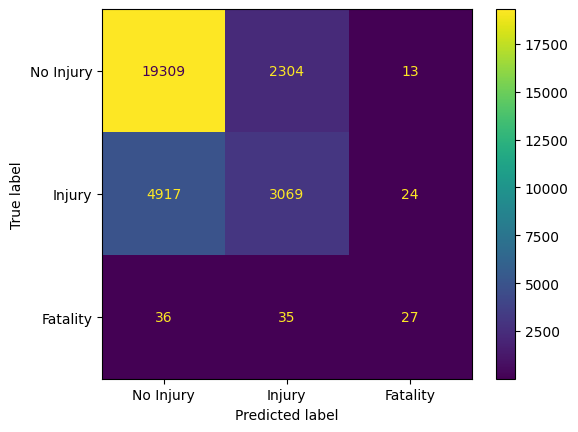

In [100]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#make a pretty confusion matrix for display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

disp.plot()

#stop gridliones from mysteriously appearing
plt.rcParams['axes.grid'] = False


### Show list of feature importance

In [101]:
#show a list of feature importance

feature_imp = pd.Series(data = tree_clf.feature_importances_, index = df_encoded.columns[2:])
feature_imp.sort_values(ascending = False, inplace = True)

#a large number of features have at least a tiny effect on categorization
print(feature_imp[:60])


Posted/Statutory Speed Limit                                                      0.116411
Total Lanes In Roadway                                                            0.088255
Number Of Motor Vehicles                                                          0.054240
Number Of Non-Motorist                                                            0.031518
Body Type_Passenger Car                                                           0.027606
Body Type_(Sport) Utility Vehicle                                                 0.026389
Trafficway Description_Two-Way, Not Divided                                       0.025401
Route Class_State                                                                 0.021759
Route Class_Local                                                                 0.020157
Weather Condition_Clear                                                           0.019879
Trafficway Description_Two-Way, Divided, Unprotected (Painted > 4 Feet) Median    0.019479

### Calculate which tree depth is best and plot a validation curve
 - this section is superseded by the hyperparameter optimization

In [114]:
#see what tree depth is best

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np

test_means = []
test_stdev = []
training_means = []
tree_depths = list(range(4, 56, 2))

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

for tree_depth in tree_depths:
    tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=tree_depth, splitter='best')
    scores = cross_validate(estimator = tree_clf, 
                            X = X, 
                            y = y, 
                            cv = cv, 
                            scoring='f1_macro',
                            return_train_score = True)
    print('Tree depth = {}, test f1 macro: {:.3f}, 95% CI: ({:.3f}, {:.3f})'.format(
        tree_depth, 
        np.mean(scores['test_score']), 
        np.mean(scores['test_score']) - 2 * np.std(scores['test_score']), 
        np.mean(scores['test_score']) + 2 * np.std(scores['test_score'])))
    print('\t    Training f1 macro: {:.4f}'.format(np.mean(scores['train_score'])))
    test_means.append(np.mean(scores['test_score']))
    test_stdev.append(np.std(scores['test_score']))
    training_means.append(np.mean(scores['train_score']))

Tree depth = 4, test f1 macro: 0.358, 95% CI: (0.331, 0.385)
	    Training f1 macro: 0.3636
Tree depth = 6, test f1 macro: 0.388, 95% CI: (0.358, 0.418)
	    Training f1 macro: 0.4030
Tree depth = 8, test f1 macro: 0.400, 95% CI: (0.368, 0.431)
	    Training f1 macro: 0.4304
Tree depth = 10, test f1 macro: 0.414, 95% CI: (0.381, 0.446)
	    Training f1 macro: 0.4744
Tree depth = 12, test f1 macro: 0.429, 95% CI: (0.383, 0.474)
	    Training f1 macro: 0.5184
Tree depth = 14, test f1 macro: 0.443, 95% CI: (0.400, 0.485)
	    Training f1 macro: 0.5598
Tree depth = 16, test f1 macro: 0.455, 95% CI: (0.429, 0.481)
	    Training f1 macro: 0.5948
Tree depth = 18, test f1 macro: 0.463, 95% CI: (0.434, 0.492)
	    Training f1 macro: 0.6311
Tree depth = 20, test f1 macro: 0.471, 95% CI: (0.441, 0.500)
	    Training f1 macro: 0.6627
Tree depth = 22, test f1 macro: 0.481, 95% CI: (0.449, 0.513)
	    Training f1 macro: 0.6903
Tree depth = 24, test f1 macro: 0.492, 95% CI: (0.461, 0.524)
	    Traini

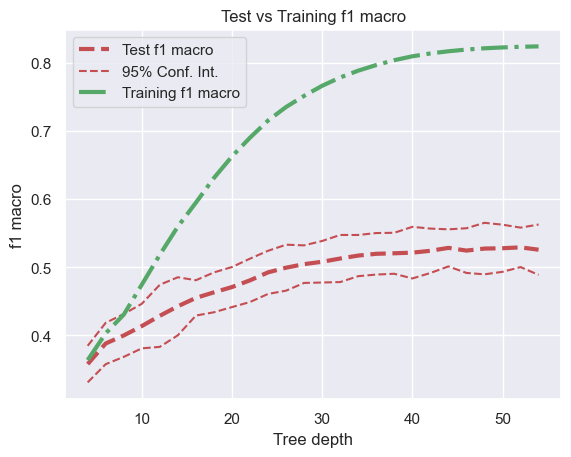

In [115]:
#plot validation curve - results show 8 is the optimal tree depth

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(tree_depths, test_means, 'r--', linewidth=3, label='Test f1 macro')
plt.plot(tree_depths, np.array(test_means) + 2 * np.array(test_stdev), 
         'r--', label='95% Conf. Int.')
plt.plot(tree_depths, np.array(test_means) - 2 * np.array(test_stdev), 'r--')
plt.plot(tree_depths, training_means, 'g-.', linewidth = 3, 
         label = 'Training f1 macro')

plt.xlabel('Tree depth')
plt.ylabel('f1 macro')
plt.title('Test vs Training f1 macro')
plt.legend()
plt.show()

### Create a visual representation of the whole tree

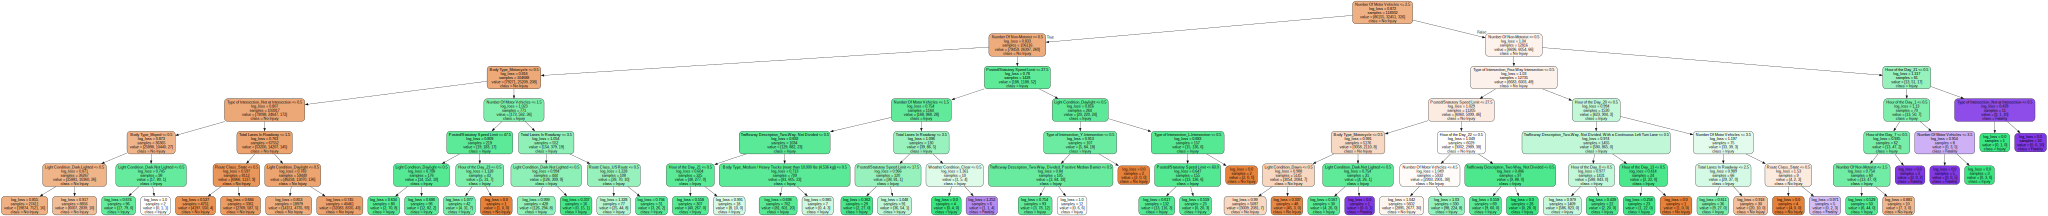

In [116]:
#use graphiz to visualize this version of the decision tree

from sklearn.tree import export_graphviz
import graphviz

feature_names = df_encoded.columns[2:]

#testing shows depth of 54, but only 6 will be created for this visualization
tree_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=6, splitter='best')

# Feature scaling is not needed
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file = 'crash_tree.dot',
    feature_names=feature_names,
    class_names=['No Injury','Injury','Fatality'],
    rounded = True,
    filled = True
)


with open('crash_tree.dot') as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

### Hyperparameter optimization
 - Best f1 score: 0.529 using {'criterion': 'log_loss', 'max_depth': 54, 'min_samples_leaf': 1, 'splitter': 'best'}

In [98]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()
max_depth = range(2, 73, 4)
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]

# define the grid 
grid = dict(max_depth = max_depth, criterion = criterion, splitter = splitter, min_samples_leaf=min_samples_leaf)

# Stratified sampling ensures that proportion of labels is maintained in test set 
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1,   # Use all CPU cores 
                           cv=cv,
                           scoring='f1_macro')

# This may take a while to compute (depending on size of search space)
grid_result = grid_search.fit(X, y)

print(f"Best f1 score: {grid_result.best_score_:0.3f} using {grid_result.best_params_}\n")

# Output the accuracy for all combintations in the grid
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best f1 score: 0.529 using {'criterion': 'log_loss', 'max_depth': 54, 'min_samples_leaf': 1, 'splitter': 'best'}

0.333702 (0.001007) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'best'}
0.309948 (0.011910) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'random'}
0.333702 (0.001007) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'splitter': 'best'}
0.315344 (0.012420) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'splitter': 'random'}
0.333702 (0.001007) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'splitter': 'best'}
0.308089 (0.011564) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'splitter': 'random'}
0.333702 (0.001007) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 8, 'splitter': 'best'}
0.299676 (0.011176) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 8, 'splitter': 'random'}
0.333702 (0.001007) wi

## Random Forest Classifier
 - this is typically more accurate than a decision tree
 - imbalanced-learn has a balanced random forest module, which can also be tested

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/crashes_encoded.csv', index_col='Unnamed: 0')
df_encoded = df.dropna()

# First 8 columns
X = df_encoded.loc[:, 'Number Of Motor Vehicles':]

# Last column
y = df_encoded.loc[:, 'Crash Severity']

# Generate the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    test_size = 0.2,
                                                    stratify=y)

forest_model = RandomForestClassifier(bootstrap=False,
                                      max_depth=46,
                                      min_samples_leaf=1,
                                      min_samples_split=2)
forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)

#show the whole sklearn classification report
target_names = ['No Injury', 'Injury', 'Fatality']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Injury       0.79      0.93      0.85     21557
      Injury       0.64      0.35      0.46      8092
    Fatality       0.62      0.15      0.25        85

    accuracy                           0.77     29734
   macro avg       0.68      0.48      0.52     29734
weighted avg       0.75      0.77      0.74     29734



### Confusion matrix

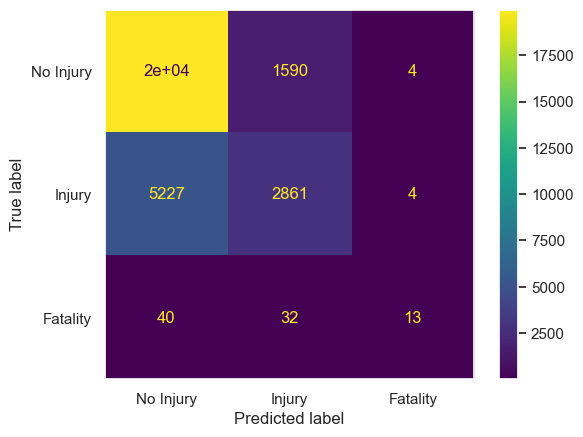

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#make a pretty confusion matrix for display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

disp.plot()

#stop gridlines from mysteriously appearing
plt.rcParams['axes.grid'] = False


### Hyperparameter optimization
 - Best f1 score: 0.527 using {'bootstrap': False, 'max_depth': 46, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [124]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
max_depth = range(2, 73, 4)
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
bootstrap = [True, False]

# define the grid 
grid = dict(max_depth = max_depth, 
            min_samples_leaf=min_samples_leaf, 
            min_samples_split=min_samples_split, 
            bootstrap=bootstrap)

# Stratified sampling ensures that proportion of labels is maintained in test set 
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1,   # Use all CPU cores 
                           cv=cv,
                           scoring='f1_macro')

# This may take a while to compute (depending on size of search space)
grid_result = grid_search.fit(X, y)

print(f"Best f1 score: {grid_result.best_score_:0.3f} using {grid_result.best_params_}\n")

# Output the accuracy for all combintations in the grid
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best f1 score: 0.527 using {'bootstrap': False, 'max_depth': 46, 'min_samples_leaf': 1, 'min_samples_split': 2}

0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.280190 (0.000004) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2}
0.280220 (0.000109) with: {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.280190 (0.0

### Compare Random Forest with Balanced Random Forest

In [127]:
#code adapted from the imbalanced-learn documentation: 
# https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/examples/ensemble/plot_comparison_ensemble_classifier.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

#load the CSV, with the first column as the index
df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/crashes_encoded.csv', index_col='Unnamed: 0')

df_encoded = df_encoded.dropna()

# First 8 columns
X = df_encoded.loc[:, 'Number Of Motor Vehicles':]

# Last column
y = df_encoded.loc[:, 'Crash Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

rf = RandomForestClassifier(n_estimators=100, random_state=0)
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, categor

In [128]:
#show the whole sklearn classification report for both

target_names = ['No Injury', 'Injury', 'Fatality']

print('Random Forest')
print(classification_report(y_test, y_pred_rf, target_names=target_names))

print('\n\nBalanced Random Forest')
print(classification_report(y_test, y_pred_brf, target_names=target_names))

Random Forest
              precision    recall  f1-score   support

   No Injury       0.79      0.92      0.85     26946
      Injury       0.61      0.35      0.44     10115
    Fatality       0.67      0.17      0.27       106

    accuracy                           0.76     37167
   macro avg       0.69      0.48      0.52     37167
weighted avg       0.74      0.76      0.74     37167



Balanced Random Forest
              precision    recall  f1-score   support

   No Injury       0.80      0.55      0.65     26946
      Injury       0.33      0.42      0.37     10115
    Fatality       0.01      0.83      0.03       106

    accuracy                           0.51     37167
   macro avg       0.38      0.60      0.35     37167
weighted avg       0.67      0.51      0.57     37167



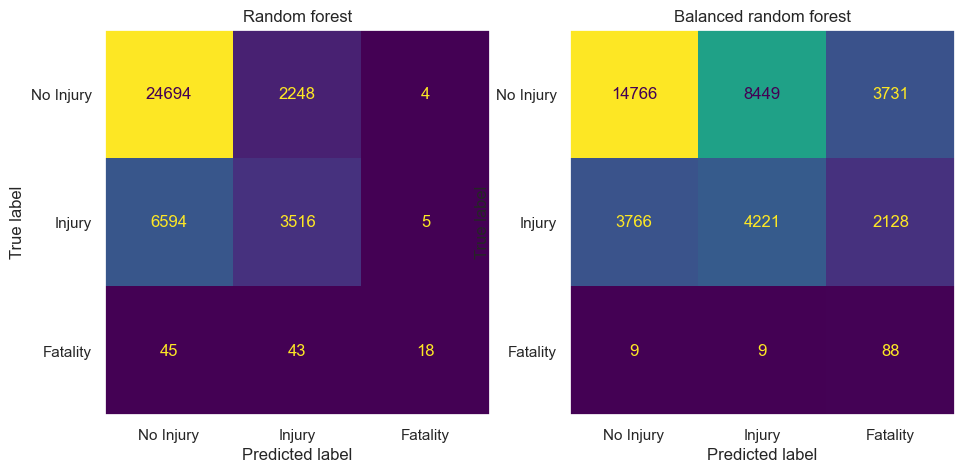

In [131]:
#show the confusion matrices
# the balanced algorithm predicts the rarer labels too frequently

fig, axs = plt.subplots(ncols=2, figsize=(11, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=axs[0], colorbar=False, display_labels=target_names)
axs[0].set_title("Random forest")

ConfusionMatrixDisplay.from_estimator(brf, X_test, y_test, ax=axs[1], colorbar=False, display_labels=target_names)
axs[1].set_title("Balanced random forest")

#stop mysterious gridlines from appearing
plt.rcParams['axes.grid'] = False

## K Nearest Neighbors
 - initially seems less accurate than decision tree or random forest, especially since it does not predict the rarest label
 - plot validation curve to determine optimal K value
 - try out related imbalanced-learn module

In [2]:
#KNN with crashes_encoded.csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#load the CSV, with the first column as the index
df_encoded = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/crashes_encoded.csv', index_col='Unnamed: 0')

df_encoded = df_encoded.dropna()

# First 8 columns
X = df_encoded.loc[:, 'Number Of Motor Vehicles':]

# Last column
y = df_encoded.loc[:, 'Crash Severity']

# Generate the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    test_size = 0.2,
                                                    stratify=y)

#normalize the data
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# define the model
classifier = KNeighborsClassifier(n_neighbors = 3, p = 3, metric='manhattan', weights='distance')

# "Train" the model
classifier.fit(X_train_scaled, y_train)

# Run the model to make predictions based on test set
y_pred = classifier.predict(X_test_scaled)

#show the whole sklearn classification report
target_names = ['No Injury', 'Injury', 'Fatality']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Injury       0.79      0.86      0.82     21557
      Injury       0.50      0.39      0.44      8092
    Fatality       0.34      0.14      0.20        85

    accuracy                           0.73     29734
   macro avg       0.54      0.46      0.49     29734
weighted avg       0.71      0.73      0.71     29734



### Confusion Matrix

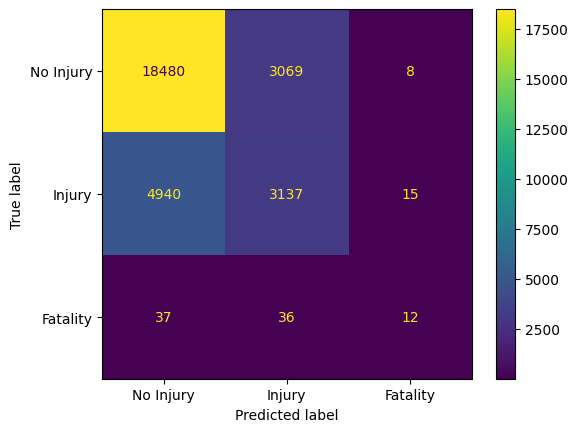

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#make a pretty confusion matrix for display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

disp.plot()

#stop mysterious gridlines from appearing
plt.rcParams['axes.grid'] = False

### Hyperparameter optimization with grid search and cross validation
 - Best f1 score: 0.494 using {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [135]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()
n_neighbors = range(3, 52, 2)
metric = ['euclidean', 'manhattan']
weights = ['uniform', 'distance']

#normalize the data
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

# define the grid 
grid = dict(n_neighbors = n_neighbors, metric = metric, weights = weights)

# Stratified sampling ensures that proportion of labels is maintained in test set 
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1,   # Use all CPU cores 
                           cv=cv,
                           scoring='f1_macro')

# This may take a while to compute (depending on size of search space)
grid_result = grid_search.fit(X_scaled, y)

print(f"Best f1 score: {grid_result.best_score_:0.3f} using {grid_result.best_params_}\n")

# Output the accuracy for all combintations in the grid
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best f1 score: 0.494 using {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

0.428877 (0.010535) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.489236 (0.016378) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.412395 (0.010403) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.490889 (0.018270) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.394465 (0.005917) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.489799 (0.018485) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.386725 (0.007958) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.485599 (0.016836) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.373728 (0.003562) with: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
0.485279 (0.015506) with: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


### Plot validation curve to determine best value for K
 - cross validating the model with 25 K values takes over an hour on my M1 Macbook Air 
 - this code is superseded by the above hyperparameter optimization

In [4]:
# NOTE: The Hyperparameter optimization section supersedes the code in this cell

#see what K value is best

from sklearn.model_selection import cross_validate
import numpy as np

test_means = []
test_stdev = []
training_means = []
K_values = list(range(3, 12, 2))

#normalize the data
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)


for K_value in K_values:
    classifier = KNeighborsClassifier(n_neighbors = K_value, p = 3, metric='manhattan', weights='distance')
    scores = cross_validate(estimator = classifier, 
                            X = X_scaled, 
                            y = y, 
                            cv = 5, 
                            return_train_score = True,
                            scoring='f1_macro')
    print('K Value = {}, test f1 macro avg: {:.5f}, 95% CI: ({:.5f}, {:.5f})'.format(
        K_value, 
        np.mean(scores['test_score']), 
        np.mean(scores['test_score']) - 2 * np.std(scores['test_score']), 
        np.mean(scores['test_score']) + 2 * np.std(scores['test_score'])))
    print('\t  Training f1 macro avg: {:.5f}'.format(np.mean(scores['train_score'])))
    test_means.append(np.mean(scores['test_score']))
    test_stdev.append(np.std(scores['test_score']))
    training_means.append(np.mean(scores['train_score']))

K Value = 3, test f1 macro avg: 0.36184, 95% CI: (0.35129, 0.37238)
	  Training f1 macro avg: 0.81349
K Value = 5, test f1 macro avg: 0.36444, 95% CI: (0.35430, 0.37457)
	  Training f1 macro avg: 0.82279
K Value = 7, test f1 macro avg: 0.36203, 95% CI: (0.35328, 0.37079)
	  Training f1 macro avg: 0.82494
K Value = 9, test f1 macro avg: 0.36061, 95% CI: (0.35186, 0.36937)
	  Training f1 macro avg: 0.82475
K Value = 11, test f1 macro avg: 0.35911, 95% CI: (0.34937, 0.36886)
	  Training f1 macro avg: 0.82558


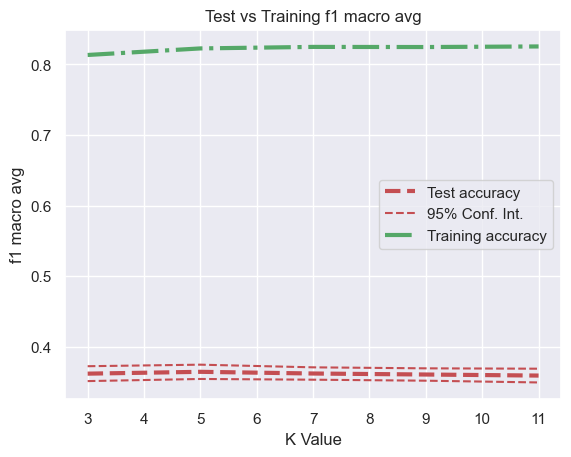

In [6]:
# NOTE: The Hyperparameter optimization section supersedes the code in this cell

#plot validation curve 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(K_values, test_means, 'r--', linewidth=3, label='Test accuracy')
plt.plot(K_values, np.array(test_means) + 2 * np.array(test_stdev), 
         'r--', label='95% Conf. Int.')
plt.plot(K_values, np.array(test_means) - 2 * np.array(test_stdev), 'r--')
plt.plot(K_values, training_means, 'g-.', linewidth = 3, 
         label = 'Training accuracy')

plt.xlabel('K Value')
plt.ylabel('f1 macro avg')
plt.title('Test vs Training f1 macro avg')
plt.legend()
plt.show()

## Tests using SMOTE from imblearn
 - this increases the frequency of the minority class members by creating more synthetically

In [11]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import pandas as pd

df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/crashes_encoded.csv', index_col='Unnamed: 0')

#drop every row with missing data
df_encoded = df.dropna()

# Define the X columns (independent variables) and y variable (response variable - what we want to predict)

# Feature columns
X = df_encoded.loc[:, 'Number Of Motor Vehicles':]

# column to be predicted
y = df_encoded.loc[:, 'Crash Severity']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1) 
Xresampled, yresampled = SMOTE().fit_resample(Xtrain,ytrain)

# define the parameters for the grid search 
# model_params = {
#     'criterion':['gini','entropy'],
#     'n_estimators':[50, 150, 250],
#     'max_features':['sqrt', 0.25, 0.5, 0.75 , 1], 
#     'min_samples_leaf':range(1, 5)
#     }

# # createrandomforestclassifiermodel 
# rf_model = RandomForestClassifier()

# #set up grid search meta-estimator
# clf = GridSearchCV(rf_model, model_params, cv=5)


#best for training set: 'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 250
#make a quicker model
clf = RandomForestClassifier(criterion='gini',
                             max_features=1,
                             min_samples_leaf=1,
                             n_estimators=250)

#train the grid search meta-estimator to find the best model 
model = clf.fit(Xresampled,yresampled)
ypred = model.predict(Xtest) #Evaluate using the test(untouched by SMOTE)
# report = classification_report(ytest, ypred, output_dict=True, target_names=['accuracy','f1-score'])
# report

#show the whole sklearn classification report
target_names = ['No Injury', 'Injury', 'Fatality']

print(classification_report(ytest, ypred, target_names=target_names))

              precision    recall  f1-score   support

   No Injury       0.81      0.78      0.80     21557
      Injury       0.47      0.50      0.48      8092
    Fatality       0.24      0.14      0.18        85

    accuracy                           0.71     29734
   macro avg       0.50      0.48      0.49     29734
weighted avg       0.71      0.71      0.71     29734



### Confusion Matrix

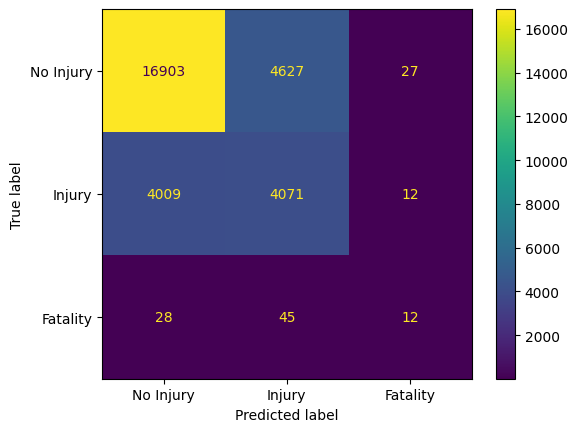

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#create the confusion matrix
cm = confusion_matrix(ytest, ypred)

#make a pretty confusion matrix for display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

disp.plot()

#stop gridliones from mysteriously appearing
plt.rcParams['axes.grid'] = False

### Hyperparameter optimization
 - Best f1 score: 0.842 using {'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 250}

In [9]:
#hyperparameter optimization for SMOTE treated test set with Random Forest

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()

param_grid = {'criterion':['gini','entropy'],
    'n_estimators':[50, 150, 250],
    'max_features':['sqrt', 0.25, 0.5, 0.75 , 1], 
    'min_samples_leaf':range(1, 5)
}

# Stratified sampling ensures that proportion of labels is maintained in test set 
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           n_jobs=-1,   # Use all CPU cores 
                           cv=cv,
                           scoring='f1_macro')

# This may take a while to compute (depending on size of search space)
grid_result = grid_search.fit(Xresampled, yresampled)

print(f"Best f1 score: {grid_result.best_score_:0.3f} using {grid_result.best_params_}\n")

# Output the accuracy for all combintations in the grid
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best f1 score: 0.842 using {'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 250}

0.839322 (0.001296) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
0.840459 (0.001275) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}
0.840968 (0.001426) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
0.824276 (0.001708) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50}
0.826886 (0.001516) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}
0.827922 (0.001619) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 250}
0.807404 (0.000955) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 50}
0.810248 (0.001201) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_s

# Prepare a different dataset for the Streamlit App

In [1]:
#prepare another CSV for the streamlit app
import pandas as pd

#ignore the first row of the csv, since it just contains the URL for the export
df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/Raw Data/export_160155_0.csv', skiprows=1, index_col='CrashId')

#remove the label from the index column, so the dataframe does not have multiple label levels
df.index.name = None

#get just the desired columns
df = df[['Crash Severity Text Format', 'Latitude', 'Longitude', 'Town Name', 'Date Of Crash', 'Time of Crash', 'Hour of the Day', 'Most Severe Injury Text Format','Number Of Motor Vehicles', 'Number Of Non-Motorist', 'Route Class Text Format', 'Road Number', 'Roadway Name', 'Average Daily Traffic', 'Weather Condition Text Format', 'Light Condition Text Format', 'Road Surface Condition Text Format', 'Type of Intersection Text Format']]
# others: Town Name, Average Daily Traffic

#check whole df length
print(len(df))

#drop the ' Text Format' part of any column names that include it
df.columns = df.columns.str.replace(' Text Format', '')

#save this encoded version as a csv
#df.to_csv('crashes2_encoded.csv')

/var/folders/cp/7f1dc54j6gv87v30bs8sfvzc0000gp/T/ipykernel_726/79687403.py:5: DtypeWarning: Columns (84,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/Raw Data/export_160155_0.csv', skiprows=1, index_col='CrashId')


88259


In [2]:
df.head()

,Crash Severity,Latitude,Longitude,Town Name,Date Of Crash,Time of Crash,Hour of the Day,Most Severe Injury,Number Of Motor Vehicles,Number Of Non-Motorist,Route Class,Road Number,Roadway Name,Average Daily Traffic,Weather Condition,Light Condition,Road Surface Condition,Type of Intersection
632460,"Injury of any type (Serious, Minor, Possible)",41.545451,-72.979654,Waterbury,2020-01-01,10:06:00,10,Possible Injury (C),2,0,State,801.0,801-E,10200.0,Clear,Daylight,Dry,Four-Way Intersection
632557,Property Damage Only,41.301400,-72.925931,New Haven,2020-01-01,01:15:00,1,No Apparent Injury (O),2,0,State,34.0,34-E,52500.0,Clear,Dark-Not Lighted,Dry,Not at Intersection
632558,Property Damage Only,41.305209,-72.900476,New Haven,2020-01-01,03:04:00,3,No Apparent Injury (O),2,0,Local,377.0,LLOYD ST,NaN,Clear,Dark-Not Lighted,Wet,Not at Intersection
632559,"Injury of any type (Serious, Minor, Possible)",41.289759,-72.892261,New Haven,2020-01-01,04:50:00,4,Possible Injury (C),2,0,USRoute,1.0,1-N,9100.0,Clear,Dark-Lighted,Dry,Four-Way Intersection
632560,Property Damage Only,41.316572,-72.951892,New Haven,2020-01-01,18:38:00,18,No Apparent Injury (O),2,0,Local,72.0,BROWNELL ST,NaN,Clear,Dark-Lighted,Dry,Not at Intersection


In [ ]:
from datetime import datetime

new_df=pd.DataFrame()

new_df['full_date'] = df['Date Of Crash'].astype(str) + ' ' + df['Time of Crash']

#make sure joining and converting works
# date_test = datetime.strptime(no_pl_df['full_date'][0], '%m/%d/%y %H:%M:%S')

# print(date_test)
# print(type(date_test))

#add new column of datetime objects to original dataframe
df = df.merge(new_df, left_index=True, right_index=True)

#now save the cleaned data
df.to_csv('/Users/asweet/Desktop/NHC Crash Data/nhc_crashes.csv')

In [31]:
import pandas as pd
import numpy as np

#drop extra unnamed columns and rename the latitude and longitude for display in Streamlit

df = pd.read_csv('/Users/asweet/Desktop/NHC Crash Data/nhc_crashes.csv', index_col='Unnamed: 0')

#df.drop(columns=['Unnamed: 0.1', 'Road Surface Condition', 'Type of Intersection', 'Most Severe Injury', 'Date Of Crash', 'Time of Crash', 'Hour of the Day', 'Light Condition'], inplace=True)
#df.drop(columns='Unnamed: 0.1', inplace=True)
#df.rename(columns={'Latitude':'lat','Longitude':'lon'}, inplace=True)
df['Town Name'] = df['Town Name'].str.replace('NewHaven', 'New Haven')


print(len(df['Town Name'].unique()))

town_list = df['Town Name'].unique().tolist()
town_list.sort()
print(town_list)

list1, list2, list3 = np.array_split(town_list, 3)

print(list1)

#df.to_csv('/Users/asweet/Desktop/NHC Crash Data/nhc_crashes.csv')

27
['Ansonia', 'Beacon Falls', 'Bethany', 'Branford', 'Cheshire', 'Derby', 'East Haven', 'Guilford', 'Hamden', 'Madison', 'Meriden', 'Middlebury', 'Milford', 'Naugatuck', 'New Haven', 'North Branford', 'North Haven', 'Orange', 'Oxford', 'Prospect', 'Seymour', 'Southbury', 'Wallingford', 'Waterbury', 'West Haven', 'Wolcott', 'Woodbridge']
['Ansonia' 'Beacon Falls' 'Bethany' 'Branford' 'Cheshire' 'Derby'
 'East Haven' 'Guilford' 'Hamden']
